# Classification

## Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd  /content/drive/MyDrive/"Colab Notebooks"/ADL/HW1/Q1/ 
!unzip /content/drive/MyDrive/"Colab Notebooks"/dataset.zip

## Define Dataloaders

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.15,shear_range=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory("./dataset/classification/train1000",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("./dataset/classification/test1000",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')

Found 20000 images belonging to 1000 classes.
Found 5000 images belonging to 1000 classes.


## Define Network

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint


embedding = ResNet50(weights= None, include_top=False, input_shape= (224,224,3))
x = embedding.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(1000, activation= 'softmax')(x)
classifier = Model(inputs = embedding.input, outputs = predictions)

In [10]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

adam = Adam(lr=0.0001)
classifier.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
mc = ModelCheckpoint('./best_model.h5', monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

## Training

In [11]:
history = classifier.fit(train_generator,validation_data=test_generator,epochs=100,verbose=1,callbacks=[mc,es])

Epoch 1/25
625/625 [==============================] - ETA: 0s - loss: 7.2072 - accuracy: 7.5000e-04
Epoch 1: val_accuracy improved from -inf to 0.00200, saving model to ./best_model.h5
625/625 [==============================] - 493s 777ms/step - loss: 7.2072 - accuracy: 7.5000e-04 - val_loss: 7.1235 - val_accuracy: 0.0020
Epoch 2/25
625/625 [==============================] - ETA: 0s - loss: 6.8371 - accuracy: 0.0025
Epoch 2: val_accuracy improved from 0.00200 to 0.00380, saving model to ./best_model.h5
625/625 [==============================] - 483s 773ms/step - loss: 6.8371 - accuracy: 0.0025 - val_loss: 6.8833 - val_accuracy: 0.0038
Epoch 3/25
625/625 [==============================] - ETA: 0s - loss: 6.5786 - accuracy: 0.0054
Epoch 3: val_accuracy improved from 0.00380 to 0.00760, saving model to ./best_model.h5
625/625 [==============================] - 484s 774ms/step - loss: 6.5786 - accuracy: 0.0054 - val_loss: 6.4075 - val_accuracy: 0.0076
Epoch 4/25
625/625 [==================

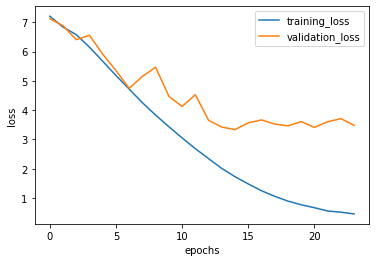

In [2]:
import matplotlib.pyplot as plt
plt.plot(history["loss"],label="training_loss")
plt.plot(history["val_loss"],label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

## Evaluate learned model

In [17]:
test_loss,test_acc = classifier.evaluate(test_generator)

157/157 [==============================] - 36s 231ms/step - loss: 3.4826 - accuracy: 0.4132


# Verification Task

## Load Dataset and trained model

In [37]:
import pandas as pd
df = pd.read_csv("/content/dataset/verification/verification_dev.csv")
classifier.load_weights("/content/drive/MyDrive/best_model.h5")

## save embedding

In [31]:
import os
import numpy as np
# %cd ./dataset/verification
!mkdir ./embedding
for img_name in os.listdir("./dev"):
    img = image.load_img("./dev/"+img_name)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /=255
    pred = embedding.predict(img_tensor).reshape((-1))
    np.save("./embedding/"+img_name.split(".")[0],pred)

## compare embbedings and calculate distance

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import keras.backend as K

pred = []
for image_1,image_2,label in df.values:
    embd1 = np.load("./embedding/"+image_1[4:].split(".")[0]+".npy")
    embd2 = np.load("./embedding/"+image_2[4:].split(".")[0]+".npy")
    distance = K.sqrt(K.sum(K.square(embd1 - embd2), axis=-1))
    if distance<=650:
        pred.append(1)
    else:
        pred.append(0)

In [82]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(df["match"].values, pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79     79600
           1       0.82      0.79      0.80     87200

    accuracy                           0.80    166800
   macro avg       0.80      0.80      0.80    166800
weighted avg       0.80      0.80      0.80    166800



In [90]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(df["match"].values, pred)
print("AUC:",metrics.auc(fpr, tpr))

AUC: 0.7992260903139551


## find good threshold with visualization 

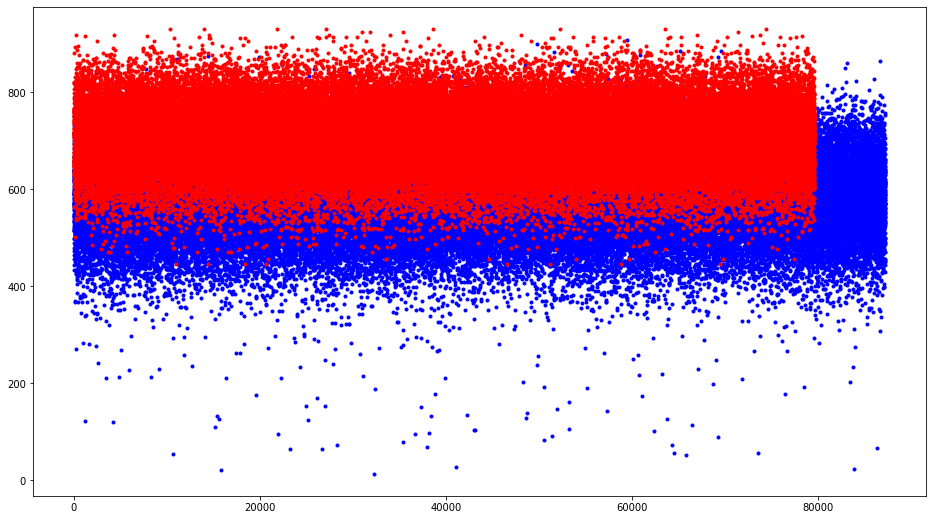

In [62]:
plt.figure(figsize=(16,9))
plt.plot(same,"b.")
plt.plot(not_same,"r.")